In [ ]:
!pip install -q transformers==4.37.2 --quiet
!pip install pydot --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 31.2 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# from collections import Counter
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.callbacks import EarlyStopping

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import BertTokenizer, TFBertModel, AutoTokenizer, AutoModel
# import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/w266_project')
df = pd.read_csv("features.csv", header = 0, sep="\t", index_col=0)

In [ ]:
# Load SciBERT tokenizer and model
model_checkpoint = "allenai/scibert_scivocab_uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint, from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
X = df[['Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words', 'Funding','Auth_country', 'Pub_country', 'Abstract']]
y = df['JIF']

train_idx, val_idx, y_train, y_val = train_test_split(range(len(df)), y, test_size=0.3, random_state=42)

In [ ]:
# Prepare categorical data
categories = ['Funding','Auth_country', 'Pub_country']
train_one_hot_data = {}
val_one_hot_data = {}
for cat in categories:
  one_hot_df = pd.get_dummies(df[cat], prefix=cat, dtype=int)
  train_one_hot_data[cat] = one_hot_df.iloc[train_idx]
  val_one_hot_data[cat] = one_hot_df.iloc[val_idx]

# Prepare numerical data
num_data = X[['Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words']]
scaler  = MinMaxScaler(feature_range=(0,1))
num_data = scaler.fit_transform(num_data)
train_num_data = num_data[train_idx]
val_num_data = num_data[val_idx]

### Model with text and metadata

In [ ]:
max_length = 400
train_encodings = bert_tokenizer(list(X['Abstract'].iloc[train_idx]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
val_encodings = bert_tokenizer(list(X['Abstract'].iloc[val_idx]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
hidden_size = 768 + 5 + 49 + 10 + 1
dropout = 0.3
bert_model.trainable = False
learning_rate = 0.0001

num_of_levels  = df['Funding'].nunique()
#Jeremy Howard provides the following rule of thumb; embedding size = min(50, number of categories/2).
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Funding embeding size: {embedding_size}')

fund_input = keras.layers.Input(shape=(num_of_levels,), name = 'fund_input')
fund_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'fund_emb')(fund_input)
fund_flat = keras.layers.Flatten(name = 'fund_flat')(fund_emb)
fund_flat = tf.keras.layers.Dropout(dropout)(fund_flat)

num_of_levels  = df['Auth_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Auth cont embeding size: {embedding_size}')

Auth_input = keras.layers.Input(shape=(num_of_levels,), name = 'Auth_input')
Auth_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Auth_emb')(Auth_input)
Auth_flat = keras.layers.Flatten(name = 'Auth_flat')(Auth_emb)
Auth_flat = tf.keras.layers.Dropout(dropout)(Auth_flat)

num_of_levels  = df['Pub_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Pub cont embeding size: {embedding_size}')

Pub_input = keras.layers.Input(shape=(num_of_levels,), name = 'Pub_input')
Pub_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Pub_emb')(Pub_input)
Pub_flat = keras.layers.Flatten(name = 'Pub_flat')(Pub_emb)
Pub_flat = tf.keras.layers.Dropout(dropout)(Pub_flat)

inp_num_data = keras.layers.Input(shape=(num_data.shape[1],), name = 'Num feat')

#Set up the BERT part of the model
bert_model.trainable = False
# BERT inputs
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')
bert_inputs = {'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask}
bert_out = bert_model(bert_inputs)
tokens = bert_out[0] #all tokens, including cls
#Add LSTM layer on top of BERT
LSTM_1 = tf.keras.layers.LSTM(units = 768, activation='tanh', return_sequences=True, dropout=dropout, recurrent_dropout=dropout, name = 'LSTM1')(tokens)
LSTM_out = tf.keras.layers.LSTM(units = 768, activation='tanh', dropout=dropout, recurrent_dropout=dropout, name = 'LSTM3')(LSTM_1)

# Concatenate all layers
conc = keras.layers.Concatenate()([LSTM_out, Auth_flat, Pub_flat, fund_flat, inp_num_data])

hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(conc)
hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)

# Create output layer
out = keras.layers.Dense(1, activation='linear', name = 'Regression_layer')(hidden1)
model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask,
                            Auth_input, Pub_input, fund_input,
                            inp_num_data], outputs=out)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])

Funding embeding size: 1
Auth cont embeding size: 47
Pub cont embeding size: 10


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 400)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 400)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 400)]                0         []                            
 tLayer)                                                                                    

In [ ]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

model.fit([ train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask,
           train_one_hot_data['Auth_country'], train_one_hot_data['Pub_country'], train_one_hot_data['Funding'],
           train_num_data],
           y_train,
           validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                            val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'], val_one_hot_data['Funding'],
                            val_num_data],
                            y_val),
           batch_size=32, epochs=60, callbacks=[early_stopping])

Epoch 1/60
100/100 [==============================] - 294s 3s/step - loss: 4.8138 - mean_squared_error: 4.8138 - val_loss: 3.7952 - val_mean_squared_error: 3.7952
Epoch 2/60
100/100 [==============================] - 272s 3s/step - loss: 3.5896 - mean_squared_error: 3.5896 - val_loss: 3.4783 - val_mean_squared_error: 3.4783
Epoch 3/60
100/100 [==============================] - 270s 3s/step - loss: 3.2702 - mean_squared_error: 3.2702 - val_loss: 3.6787 - val_mean_squared_error: 3.6787
Epoch 4/60
100/100 [==============================] - 273s 3s/step - loss: 2.9690 - mean_squared_error: 2.9690 - val_loss: 3.5847 - val_mean_squared_error: 3.5847
Epoch 5/60
100/100 [==============================] - 270s 3s/step - loss: 2.5802 - mean_squared_error: 2.5802 - val_loss: 3.3704 - val_mean_squared_error: 3.3704
Epoch 6/60
100/100 [==============================] - 266s 3s/step - loss: 2.3387 - mean_squared_error: 2.3387 - val_loss: 3.7680 - val_mean_squared_error: 3.7680
Epoch 7/60
100/100 [==

In [ ]:
pred = model.predict([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                      val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'], val_one_hot_data['Funding'],
                      val_num_data])

43/43 [==============================] - 25s 516ms/step


Text(0, 0.5, 'Observed')

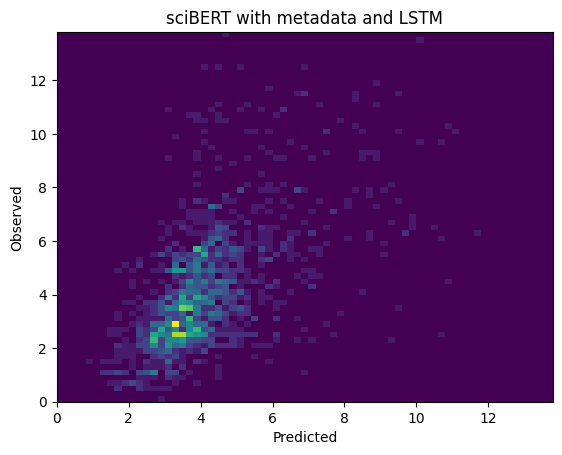

In [ ]:
predictions = pred.reshape((-1))
fig, ax = plt.subplots()
ax.hist2d(predictions, y_val , bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_title('sciBERT with metadata and LSTM')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')

In [ ]:
np.corrcoef(predictions, y_val)

array([[1.        , 0.57162597],
       [0.57162597, 1.        ]])

In [ ]:
p = os.path.abspath('.')
file_path = os.path.join(p, 'results_csv', 'scibert_meta_lstm.csv')
df_to_save.to_csv(file_path, sep = '\t')